<center>
    <h1> INF510 - Advanced Computational Methods  </h1>
    <h2> Final Project - Stable computation of differentiation matrices with RBFs  </h2> 
</center>

* Martín Villanueva - `martin.villanueva@usm.cl` - **rol:** 201104012-0

_DI UTFSM. February 2018._

In [455]:
#%matplotlib notebook
%matplotlib inline 

import numba
import numpy as np
import numpy.fft as fft

import scipy as sp
from scipy.sparse import csr_matrix, identity, kron
from scipy.sparse.linalg import spsolve
from scipy.linalg import toeplitz

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed, IntSlider, FloatSlider
import ghalton
import time
import distmesh as dm

### Helper functions

In the cell below there are implementation of functions used across this notebook. 

In [513]:
def cheb(N):
    if N==0:
        D=0.
        x=1.
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

def wireframe_plot(xx, yy, vv, title=None, figsize=(10,7)):  
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(xx, yy, vv, linewidth=1, rstride=1, 
                    cstride=1, cmap='Blues', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.view_init(elev=30., azim=300.)
    if title is not None:
        plt.title(title)
    plt.show()

def surface_plot(xx, yy, vv, title=None, figsize=(10,7)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, vv, linewidth=10, rstride=1, 
                    cstride=1, cmap='Blues', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.view_init(elev=30., azim=300.)
    if title is not None:
        plt.title(title)
    plt.show()
    
def wireframe_plot2(xx1,yy1,vv1,xx2,yy2,vv2, figsize=(16,5), 
                    title1="", title2=""):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_wireframe(xx1, yy1, vv1, linewidth=1, rstride=1, 
                    cstride=1, cmap='Blues', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.view_init(elev=30., azim=300.)
    ax.set_title(title1, fontsize=20)
    
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_wireframe(xx2, yy2, vv2, linewidth=1, rstride=1, 
                    cstride=1, cmap='Blues', alpha=0.9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.view_init(elev=30., azim=300.)
    ax.set_title(title2, fontsize=20)
    plt.show()    

## 1. Introduction

Radial Basis functions (RBF) approximation, is emerging as an important method for solving problems of interpolation, approximation, and partial differential equations (PDEs), for data given at scattered node locations, with no trivial/regular geometry or with domains in higher dimensions. Between their major advantages we highlight its geometrical flexibility (more suitable for real-world problems), its ability to adapt it to boundary layer problems, and the ease of implementation. 

In practical cases, the convergence of RBF methods has often been hampered by ill-conditioning as the shape of the basis functions become flatter. However, this problem has been treated by preconditioning and changes of basis [1]. Another disadvantage of this method is its computational complexity, which is $O(N^2)$ with $N$ the number of basis radial functions. Usually the value of $N$ should be high as the dimensionality of the problem increases. However, multiple optimization have been implemented in the past years (based on fast multipole methods, domain decomposition, among others) making RBF methods a very versatile and useful tool.

In this work we focus on the problem of computing differentiation matrices [citar libro guía] by using RBF approximations. By differentiation matrix we mean the matrix that connects a certain derivative of function evaluated at the node points, to the function values at the node points:
$$
D_x \mathbf{u} = \mathbf{w},
$$
where $\mathbf{u}$ is the vector of the function evaluated at the node points, $D_x$ is the differentiation matrix, and $\mathbf{w}$ is the approximation of the derivatives of the functions at the node points. Differentiation matrices are needed when solving PDEs problems, which is what we do in this work.

In this document we explain, implement and test RBF approximations to compute differentiation matrices. As baseline methods, we implement and compare with __fordward differences of second order__ and __spectral methods__ through Chebyshev differentiation matrices.

Along this document, we take as test problem the well-known 2D Poisson equation with Dirichlet boundary conditions:

\begin{align}
\Delta u(x,y) &= u_{xx}(x,y) + u_{yy}(x,y) = f(x,y) \ \ \ \ \text{for} \ (x,y) \in \Omega, \\
u(x,y) &= g(x,y) \ \ \ \ \ \ \ \ \  \ \ \  \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \  \  \ \ \ \ \ \ \ \ \  \ \text{for} \ (x,y) \in \partial \Omega.
\end{align}



## 2. Computing Differentiation Matrices with RBF approximations


### 2.1 RBF interpolators

A standard radial basis function interpolator to data $f_j$ given at __scattered__ nodes points $\mathbf{x}_j$ (for $j=1,\ldots,N$) has the form:

$$
s_{\epsilon}(\mathbf{x}) = \sum_{i=1}^N \lambda_i \phi(\epsilon ||\mathbf{x}-\mathbf{x}_i||^2),
$$

where $\phi(r)$ is a __radial basis function__, and $\epsilon$ is the __shape parameter__ which control the width of the function. Decreasing $\epsilon$ leads to a flatter function. In this work we will only consider Gaussian radial basis functions: $\phi(r) = \exp(-r^2)$. 

The unknown coefficients $\lambda_j$ are determined through the interpolation conditions $u_{\epsilon}(\mathbf{x}_i) = f_i$ for $i=1,\ldots,N$, leading to a linear system of equations. We define and use now on $X=\{\mathbf{x}_1, \ldots, \mathbf{x}_N \}$ as the set of node points, aka, collocation points. Evaluating $u$ at this set of points give us the following system of equations: 

$$
\underbrace{\begin{pmatrix}
\phi(\epsilon||\mathbf{x}_1-\mathbf{x}_1||^2) &\cdots &\phi(\epsilon||\mathbf{x}_1-\mathbf{x}_N||^2) \\
\vdots & \ddots &\vdots \\
\phi(\epsilon||\mathbf{x}_N-\mathbf{x}_1||^2) &\cdots &\phi(\epsilon||\mathbf{x}_N-\mathbf{x}_N||^2) 
\end{pmatrix}}_{\Phi_X}
\underbrace{\begin{pmatrix}
\lambda_1 \\ \vdots \\ \lambda_N
\end{pmatrix}}_{\boldsymbol{\lambda}} =
\underbrace{\begin{pmatrix}
u(\mathbf{x}_1) \\ \vdots \\ u(\mathbf{x}_N)
\end{pmatrix}}_{\mathbf{u}_X}.
$$

If the data $f_i$ is sampled from a smooth function at different points positions, highly accurate interpolation results are typically achieved. However note that as $\epsilon \rightarrow 0$, the basis function becomes nearly flat, and then $\Phi_X$ is nearly singular. The problem of properly setting $\epsilon$ is one of the __major disadvantajes__ of RBF method.


### 2.2 Computing Differentiation Matrices

Once we have computed the weights $\boldsymbol{\lambda}$ by solving the previous linear system equations, we have the continuous approximation $s_{\epsilon}(\mathbf{x})$ of $u(\mathbf{x})$. Then it is possible to explicitly compute the derivatives of $s_{\epsilon}(\mathbf{x})$ and evaluate it at any set of scattered points in $\Omega$.

Since partial derivative are a linear operator, we have the following:

\begin{align}
\frac{\partial}{\partial x} u(\mathbf{x}) &= \sum_{i=1}^N \lambda_i \frac{\partial}{\partial x} \left(\phi(\epsilon ||\mathbf{x}-\mathbf{x}_i ||^2) \right), \\
\frac{\partial}{\partial y} u(\mathbf{x}) &= \sum_{i=1}^N \lambda_i \frac{\partial}{\partial y} \left(\phi(\epsilon ||\mathbf{x}-\mathbf{x}_i ||^2) \right).
\end{align}

Moreover, the same happens with any linear differential operator $\mathcal{L}$: 

$$
\mathcal{L}(u(\mathbf{x})) = \sum_{i=1}^N \lambda_i \mathcal{L}\left(\phi(\epsilon ||\mathbf{x}-\mathbf{x}_i ||^2) \right).
$$

where $\mathcal{L}\phi$ is the functions obtained when $\mathcal{L}$ is applied to the basis function $\phi$.

Assume we want to apply the differential operator $\mathcal{L}$ to a solution function $u(\mathbf{x})$ at a set of __evaluation points__ $Y = \{ \mathbf{y}_1, \ldots, \mathbf{y}_M \}$, given the solution values at the set of node points $X$. The way to compute it would be evaluating $\mathcal{L}(u(\mathbf{x}))$ at the set $Y$:

\mathcal{L}

$$
\underbrace{\begin{pmatrix}
\mathcal{L}\phi(\epsilon||\mathbf{y}_1-\mathbf{x}_1||^2) &\cdots &\mathcal{L}\phi(\epsilon||\mathbf{y}_1-\mathbf{x}_N||^2) \\
\vdots & \ddots &\vdots \\
\mathcal{L}\phi(\epsilon||\mathbf{y}_M-\mathbf{x}_1||^2) &\cdots &\mathcal{L}\phi(\epsilon||\mathbf{x}_M-\mathbf{x}_N||^2) 
\end{pmatrix}}_{\Phi_Y^{\mathcal{L}}}
\underbrace{\begin{pmatrix}
\lambda_1 \\ \vdots \\ \lambda_N
\end{pmatrix}}_{\boldsymbol{\lambda}} =
\underbrace{\begin{pmatrix}
\mathcal{L}u(\mathbf{y}_1) \\ \vdots \\ \mathcal{L}u(\mathbf{y}_M)
\end{pmatrix}}_{\mathcal{L} \mathbf{u}_{\mathcal{I}}}
$$

Finally we obtain the following expression:

$$
\mathcal{L}\mathbf{u}_Y = \Phi_Y^{\mathcal{L}}\boldsymbol{\lambda} = \Phi_Y^{\mathcal{L}} \Phi_X^{-1} \mathbf{u}_X,
$$

and then the RBF approximated differentiation matrix is $\Phi_Y^{\mathcal{L}} \Phi_X^{-1}$. Note that unlike the Chebyshev differentiation matrix, this differentiation matrix __has no explicit form__. Furthermore, each time we want to compute $\mathcal{L}\mathbf{u}_Y$ we have to solve a linear system of equations. However, it has the advantage of not being restricted in the sets $X$ and $Y$ to the Chebyshev points. 


### 2.3 How to solve a Poisson equation with RBF differentiation matrices?

Let's consider the Poisson problem:

\begin{align}
\Delta u &= f \ \ \ \ \text{for} \ (x,y) \in \Omega, \\
u &= g  \ \ \ \ \text{for} \ (x,y) \in \partial \Omega.
\end{align}

The collocation process involves four steps:
1. First, we discretize the domain $\Omega$ with $N = N_i + N_b$ node points, where $N_i$ is the number of interior points, and $N_b$ is the number of boundary points.
2. Second, the Poisson equation is __collocated__ at the interior points for approximating the laplacian. This results in a underdetermined linear system of size $N_i\times N$. 
3. Next, the previous system is augmented with $N_b$ equations obtained evaluating the boundary conditions. 
4. Finally, we solve the linear system of equations to obtain $\boldsymbol{\lambda}$.


We define $\mathcal{I}$ the set of $N_i$ interior points in $\Omega$, and $\mathcal{B}$ the set of $N_b$ boundary points in $\partial \Omega$.  The set of __node points__ (RBF collocation points) correspond to $X = \mathcal{I}\cup \mathcal{B}$.

The first system of equations is:

$$
\underbrace{\begin{pmatrix}
\Delta \phi(\epsilon||\mathbf{x}_1-\mathbf{x}_1||^2) &\cdots &\Delta \phi(\epsilon||\mathbf{x}_1-\mathbf{x}_N||^2) \\
\vdots & \ddots &\vdots \\
\Delta \phi(\epsilon||\mathbf{x}_{N_i}-\mathbf{x}_1||^2) &\cdots &\Delta \phi(\epsilon||\mathbf{x}_{N_i}-\mathbf{x}_N||^2) 
\end{pmatrix}}_{\Phi_{\mathcal{I}}^{\Delta}}
\underbrace{\begin{pmatrix}
\lambda_1 \\ \vdots \\ \lambda_N
\end{pmatrix}}_{\boldsymbol{\lambda}} =
\underbrace{\begin{pmatrix}
f(\mathbf{x}_1) \\ \vdots \\ f(\mathbf{x}_{N_i})
\end{pmatrix}}_{ \mathbf{f}_{\mathcal{I}}},
$$

with $\Phi_{\mathcal{I}}^{\Delta}$ of size $N_i \times N$. The second system of equations is:

$$
\underbrace{\begin{pmatrix}
\phi(\epsilon||\mathbf{x}_{N_i+1}-\mathbf{x}_1||^2) &\cdots & \phi(\epsilon||\mathbf{x}_{N_i+1}-\mathbf{x}_N||^2) \\
\vdots & \ddots &\vdots \\
\phi(\epsilon||\mathbf{x}_{N}-\mathbf{x}_1||^2) &\cdots &\phi(\epsilon||\mathbf{x}_{N}-\mathbf{x}_N||^2) 
\end{pmatrix}}_{\Phi_{\mathcal{B}}}
\underbrace{\begin{pmatrix}
\lambda_1 \\ \vdots \\ \lambda_N
\end{pmatrix}}_{\boldsymbol{\lambda}} =
\underbrace{\begin{pmatrix}
g(\mathbf{x}_{N_i+1}) \\ \vdots \\ g(\mathbf{x}_{N})
\end{pmatrix}}_{ \mathbf{g}_{\mathcal{B}}},
$$

with $\Phi_{\mathcal{B}}$ of size $N_b \times N$. Finally, the linear system of equations to solve is:

$$
\underbrace{\begin{pmatrix}
\Phi_{\mathcal{I}}^{\Delta} \\
\Phi_{\mathcal{B}}
\end{pmatrix}}_{A} \boldsymbol{\lambda} =
\underbrace{\begin{pmatrix}
\mathbf{f}_{\mathcal{I}} \\
\mathbf{g}_{\mathcal{B}}
\end{pmatrix}}_{b}.
$$.

As a final comment, note that for a grid of size $L$ (for $x$ and $y$), we have a total of $L^2$ node points. Then the matrix $A$ is of size $L^2 \times L^2$. Spectral (Chebyshev) method and Forward Differences method requires to solve a problem of the same size for such grid.



***
***
## 3 Method Implementations

### 3.1 Test function

Below we define the test function we use to validate our results (compare the methods), which is the same used in [1]:

$$u_1(x,y) = \sin(2\pi x) \sin(\pi y), \ \ \ \text{with} \ \ \ \Delta u_1(x,y)=f_1(x,y) = -5 \pi^2 \sin(2 \pi x) \sin(\pi y).$$

We also define some other $f$ functions (RHS function of Poisson equation) that we test along this work.

In [36]:
def u_test(x,y):
    return np.sin(2*np.pi*x)*np.sin(np.pi*y)

def f_test(x,y):
    return -5*np.pi**2*np.sin(2*np.pi*x)*np.sin(np.pi*y)

def f_test2(x,y):
    return 10*np.sin(8*x*(y-1))

def f_test3(x,y):
    return (x**2+y**2-0.25)**2

***
***
### 3.2 Finite differences

In this section we implement finite differences (FD) of second order, as one of the baseline method used for with comparison spectral and RBF implementations. This implementation is based on [4]

In [683]:
def fd_poisson_solver(N=32, f_func=None, g_func=None):
    """
    Code taken from:
    https://github.com/tclaudioe/Scientific-Computing/blob/master/SC2/U4_EDP_elipticas.ipynbt
    """
    # Discretize x and y
    x = np.linspace(-1., 1., N+1)
    y = np.linspace(-1., 1., N+1)
    xgrid,ygrid = np.meshgrid(y, x)
    xx = xgrid.ravel()
    yy = ygrid.ravel()

    # Define the discretization parameters
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    
    # Create the matrix and the right hand size vector
    A = np.zeros([(N+1)*(N+1), (N+1)*(N+1)])
    b = np.zeros([(N+1)*(N+1), 1])
        
    # Define global indexing
    def index(i, j, nCols=(N+1)):
        return i + j*nCols
    
    # Fill up the matrix and right hand side vector
    for i in range(N+1):
        for j in range(N+1):
            k = index(i,j)
            if j==0:   # y=ymin, bottom
                A[k,k] =  1.
                b[k] = g_func["bottom"](x[i])
            elif i==N: # x=xmax, right
                A[k,k] =  1.
                b[k] = g_func["right"](y[j])
            elif j==N: # y=ymax, top
                A[k,k] =  1.
                b[k] = g_func["top"](x[i])
            elif i==0: # x=xmin, left
                A[k,k] =  1.
                b[k] = g_func["left"](y[j])
            else:
                A[k, k] = -2./dx**2 - 2./dy**2
                A[k,index(i+1,j)] =  1./dx**2
                A[k,index(i-1,j)] =  1./dx**2
                A[k,index(i,j-1)] =  1./dy**2
                A[k,index(i,j+1)] =  1./dy**2
                b[k] = f_func(x[i], y[j])

    # Solve the linear system
    u = np.linalg.solve(A, b)
    return xgrid, ygrid, u.reshape((N+1,N+1))

In the cell below we run the implemented FD method over the Poisson problem, in order to test it is working properly.

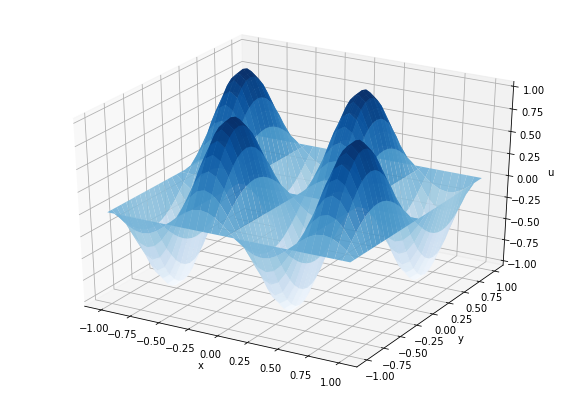

In [5]:
# boundary conditions
g1 = lambda x : 0; g2 = lambda x : 0
g3 = lambda y : 0; g4 = lambda y : 0
g = {"bottom":g1, "top":g2, "left":g3, "right":g4}

xx,yy,uu = fd_poisson_solver(N=32, f_func=f_test, g_func=g)
surface_plot(xx,yy,uu)

***
***
### 3.3 Spectral method

In the cell below is our implementation of spectral method to solve Poisson problems, which is Chebyshev Differentiation matrices [3]. Note that two approaches are implemented; The first based in the Kronecker's trick requires to solve an sparse system of equations. The second is based in GMRes. 

In practice we use only the first approach, because we make sure to obtain the real value of the approximation. The _Kronecker approach_ was implemented with sparse methods from `scipy.sparse`.

In [8]:
def poisson_solver1(A,B):
    """
    Solution to poisson equation with 
    spectral methods (Kronecker's trick)
    """
    n = A.shape[0]
    # sparse representations are used
    A = csr_matrix(A)
    I = identity(n)
    L = kron(I,A,format="csr")+kron(A,I,format="csr")
    b = np.ravel(B)
    x = spsolve(L, b)
    return np.reshape(x, (n,n)),L

def Lfun(A,x):
    U = x.reshape(A.shape, order="F")
    ret = np.dot(A,U)+np.dot(U,A.T)
    return ret.ravel(order="F")

def poisson_solver2(A, B, m=100, threshold=1e-12):
    """
    Approximate solution to the Sylvester equation
    with GMRes
    
    GMRes code adapted from:
    https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/10_GMRes.ipynb
    """
    b = B.ravel()
    n = b.shape[0]
    x0 = np.zeros(n)
    r0 = b - Lfun(A, x0)  # matrix-free
    nr0 = np.linalg.norm(r0)
    Q = np.zeros((n,m+1))
    H = np.zeros((m+1,m))
    Q[:,0] = r0 / nr0
    flag_break=False
    for k in range(min((m,n))):
        y = Lfun(A, Q[:,k])  # matrix-free
        for j in range(k+1):
            H[j][k] = np.dot(Q[:,j], y)
            y = y - np.dot(H[j][k],Q[:,j])
        if k+1<n:
            H[k+1][k] = np.linalg.norm(y)
            if (np.abs(H[k+1][k]) > 1e-16):
                Q[:,k+1] = y/H[k+1][k]
            else:
                flag_break=True
            e1 = np.zeros((k+1)+1); e1[0]=1
            H_tilde=H[0:(k+1)+1,0:k+1]
        else:
            H_tilde=H[0:k+1,0:k+1]
        ck = np.linalg.lstsq(H_tilde, nr0*e1, rcond=-1)[0] 
        if k+1<n:
            x = x0 + np.dot(Q[:,0:(k+1)], ck)
        else:
            x = x0 + np.dot(Q, ck)
        if flag_break:
            break
    return np.reshape(x, (int(np.sqrt(n)),int(np.sqrt(n)))), H, Q

def spectral_poisson_solver(N=32, f_func=None, method="kronecker"):
    D,x = cheb(N)
    D2 = np.dot(D,D)
    D2 = D2[1:-1,1:-1]
    x = x[1:-1]; y = x
    xx,yy = np.meshgrid(x, y)
    ff = f_func(xx,yy)
    if method=="kronecker":
        U,L = poisson_solver1(D2,ff)
    if method=="gmres":
        U,_,_ = poisson_solver2(D2,ff)
    return xx,yy,U

In the cell below we run our implementation of the spectral method, to verify it is working properly.

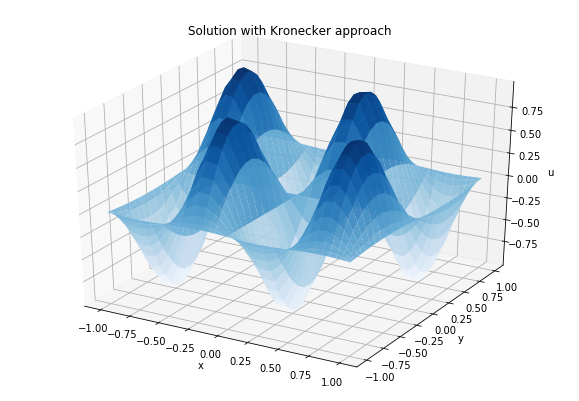

In [9]:
# Solution obtained with the first approach
xx,yy,uu = spectral_poisson_solver(N=32, f_func=f2)
surface_plot(xx,yy,uu, title="Solution with Kronecker approach")
#wireframe_plot(xx, yy, uu, title="Solution with Kronecker approach")

***
***
## 3.4 RBF Methods

In order to build the $\Phi_{\mathcal{B}}$ and $\Phi_{\mathcal{I}}^{\Delta}$ matrices, we need to evaluate the RBF functions and its derivatives:

\begin{align}
\phi_j(x,y) &= \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right) \\
\frac{\partial^2}{\partial x^2}\phi_j(x,y) &= 2\epsilon^2 \left( 2 \epsilon^2 (x-x_j)^2 -1 \right) \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right) \\
\frac{\partial^2}{\partial y^2}\phi_j(x,y) &= 2\epsilon^2 \left( 2 \epsilon^2 (y-y_j)^2 -1 \right) \exp\left(-\epsilon^2 ((x-x_j)^2+(y-y_j)^2)\right) \\
\end{align}

In the two cells below we implement the functions that performs the task of building the $\Phi_{\mathcal{B}}$ and $\Phi_{\mathcal{I}}^{\Delta}$ matrices.

Note that `numba` JIT was used in order to improve the performance of creation of these matrices.

In [27]:
eps = 10.

@numba.jit(nopython=True)
def phi(x, y, eps=eps):
    return np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d1x_phi(x, y, eps=eps):
    return (-2*eps**2) * x * np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d2x_phi(x, y, eps=eps):
    return ((4*eps**4)*x**2 - 2*eps**2) * np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d1y_phi(x, y, eps=eps):
    return (-2*eps**2) * y * np.exp(-eps**2 *(x**2+y**2))

@numba.jit(nopython=True)
def d2y_phi(x, y, eps=eps):
    return ((4*eps**4)*y**2 - 2*eps**2) * np.exp(-eps**2 *(x**2+y**2))

In [28]:
@numba.jit("float64[:,:] (float64[:], float64[:], float64[:], float64[:], float64)", nopython=True)
def build_phi_matrix(x_col, y_col, x_eva, y_eva, eps):
    N = len(x_col)
    M = len(x_eva)
    Phi = np.empty((M,N))
    for i in range(M):
        for j in range(N):
            Phi[i,j] = phi(x_eva[i]-x_col[j], y_eva[i]-y_col[j], eps)
    return Phi

@numba.jit("float64[:,:] (float64[:], float64[:], float64[:], float64[:], float64)", nopython=True)
def build_Lphi_matrix(x_col, y_col, x_eva, y_eva, eps):
    N = len(x_col)
    M = len(x_eva)
    LPhi = np.empty((M,N))
    for i in range(M):
        for j in range(N):
            LPhi[i,j] = d2x_phi(x_eva[i]-x_col[j], y_eva[i]-y_col[j], eps) + \
                        d2y_phi(x_eva[i]-x_col[j], y_eva[i]-y_col[j], eps)
    return LPhi

In the cell below is our implementation of the RBF methods to solve Poisson problems through differentiation matrices. The current version is flexible enough to accept different $f$ and $g$ functions, and scattered node points over irregular domains. We will show this features in the next sections.

In [561]:
def rbf_poisson_solver(N=32, f_func=None, g_func=None, eps=10., verbose="True",
                       x_nodes=None, y_nodes=None, x_interior=None, y_interior=None,
                       x_boundary=None, y_boundary=None, irregular=False):
    # generating interior/collocation and boundary points
    x = np.linspace(-1.,1.,N+1)
    y = np.linspace(-1.,1.,N+1)
    xx,yy = np.meshgrid(x, y)
    # node points
    if x_nodes is None and y_nodes is None:
        x_nodes = xx.ravel()
        y_nodes = yy.ravel() 
    # interior points
    if x_interior is None and y_interior is None:
        x_interior = xx[1:-1, 1:-1].ravel()
        y_interior = yy[1:-1, 1:-1].ravel()
    # boundary points
    if x_boundary is None and y_boundary is None:
        x_boundary = np.concatenate( (xx[0,:],xx[1:,-1],xx[-1,:-1,],xx[1:-1,0]) )
        y_boundary = np.concatenate( (yy[0,:],yy[1:,-1],yy[-1,:-1,],yy[1:-1,0]) )

    if verbose:
        plt.figure(figsize=(6,6))
        plt.scatter(x_interior, y_interior)
        plt.scatter(x_boundary, y_boundary, c="red")
        plt.grid()
        plt.show()
        print("Number of interior points: {0}".format(len(x_interior)))
        print("Number of boundary points: {0}".format(len(x_boundary)))
        print("Number of node points: {0}".format(len(x_nodes)))
    
    # interior evaluation
    Lphi = build_Lphi_matrix(x_nodes, y_nodes, x_interior, y_interior, eps)
    ff = f_func(x_interior, y_interior)

    # boundary evaluation
    Phi = build_phi_matrix(x_nodes, y_nodes, x_boundary, y_boundary, eps)
    if g_func is None:
        # by defaul 0 boundary conditions are set
        bb = np.zeros(len(x_boundary))
    else:
        if isinstance(g_func,dict):
            bb = np.concatenate([g_func["bottom"](xx[0,:]),
                                 g_func["right"](yy[1:,-1]),
                                 g_func["top"](xx[-1,:-1,]),
                                 g_func["left"](yy[1:-1,0])])
        else:
            bb = g_func(x_boundary, y_boundary)
    
    # building and solving the linear system
    A = np.vstack((Lphi,Phi))
    b = np.hstack((ff,bb))
    lam = np.linalg.solve(A,b)
    
    if irregular:
        return lam
    else:
        # retrieving the solution
        Phi = build_phi_matrix(x_nodes, y_nodes, x_nodes, y_nodes, eps)
        u = np.dot(Phi, lam)
        uu = u.reshape((N+1,N+1))
        return xx,yy,uu

As with the other methods, we test our implementation to solve the basic Poisson problem. In the first cell below the problem is solved and the interior and boundary points are shown as output. In the second cell below is the obtained solution.

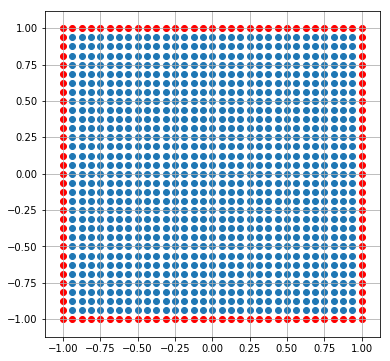

Number of interior points: 961
Number of boundary points: 128
Number of node points: 1089


In [30]:
xx,yy,uu = rbf_poisson_solver(N=32, f_func=f_test)

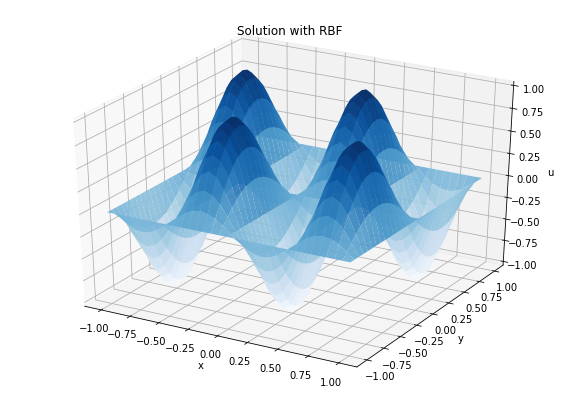

In [31]:
surface_plot(xx, yy, uu, title="Solution with RBF")
#wireframe_plot(xx, yy, uu, title="Solution with RBF")

***
***
##  4. Numerical and Computational Comparison between Forward Difference, Spectral method and RBF method

Below we define the errors measures used to compare the methods. We consider $u^{\text{approx}}$ as the approximation obtained with one of the numerical methods, and $u^{\text{real}}$ the real function. 

In many cases the 2D-grids differ for the different methods; FD and RBF use an equispaced grid while Spectral method use a Chebyshev grid. Then, to make fair comparisons relative measures are added to the experiments. They normalize the differences between $u^{\text{real}}$ and $u^{\text{approx}}$ by dividing by $u^{\text{real}}$.

\begin{align}
RMS &= \frac{\sqrt{\sum_{i=1}^{N^2} (u_i^{\text{real}}-u_i^{\text{approx}})^2 }}{\sum_{i=1}^N u_i^{\text{real}}} \\
||\mathbf{u}^{\text{real}} - \mathbf{u}^{\text{approx}} ||_{\infty} &= \max_{1\leq i \leq N^2}  \left|u_i^{\text{real}}-u_i^{\text{approx}}\right| 
\end{align}

The second measure, is the proposed (and used) in [1].



#### Experiments

The cells below run the three Poisson solver methods for grid sizes of $N=[10,20,30,40,50,60,70,80,90,100]$. For each run, `RMS`, $||\cdot||$ and execution time are measured. 

In [52]:
############################################
# Measures for FD
############################################

rms_error_fd = []
max_error_fd = []
times_fd = []
for N in range(10, 101, 10):
    t0 = time.time()
    xx,yy,uu = fd_poisson_solver(N=N, f_func=f_test, g_func=g)
    times_fd.append( time.time()-t0 )
    uu2 = u_test(xx,yy)
    rms_error_fd.append( np.sqrt(np.sum((uu2-uu)**2)) )
    max_error_fd.append( np.max(np.abs(uu2-uu)) )

In [53]:
############################################
# Measures for Spectral
############################################

rms_error_spec = []
max_error_spec = []
times_spec = []
for N in range(10, 101, 10):
    t0 = time.time()
    xx,yy,uu = spectral_poisson_solver(N=N, f_func=f_test)
    times_spec.append( time.time()-t0 )
    uu2 = u_test(xx,yy)
    rms_error_spec.append( np.sqrt(np.sum((uu2-uu)**2)) )
    max_error_spec.append( np.max(np.abs(uu2-uu)) )

In [ ]:
############################################
# Measures for RBF
############################################

def find_best_eps(N, eps_min, eps_max, f, u):
    """
    Find the optimal eps (between eps_min and eps_max)
    for the RBF interpolation problem of size N
    """
    eps_arr = np.arange(eps_min, eps_max+0.01, 1.)
    eps_opt = 100.; min_rms = 100.
    for eps in eps_arr:
        xx,yy,uu = rbf_poisson_solver(N, f_func=f2, eps=eps, verbose=False)
        uu2 = u(xx,yy)
        rms = np.sqrt(np.sum((uu2[1:-1,1:-1]-uu[1:-1,1:-1])**2))
        max = np.sqrt(np.sum((uu2[1:-1,1:-1]-uu[1:-1,1:-1])**2))
        if rms < min_rms:
            opt_eps = eps
            min_rms = rms
    return opt_eps

rms_error_rbf = []
max_error_rbf = []
times_rbf = []
eps_opt= []
for N in range(10, 101, 10):
    best_eps = find_best_eps(N, 1., 5., f_test, u_test)
    eps_opt.append(best_eps)
    t0 = time.time()
    xx,yy,uu = rbf_poisson_solver(N=N, f_func=f_test, eps=best_eps, verbose=False)
    times_rbf.append( time.time()-t0 )
    uu2 = u_test(xx,yy)
    rms_error_rbf.append( np.sqrt(np.sum((uu2[1:-1,1:-1]-uu[1:-1,1:-1])**2)) )
    max_error_rbf.append( np.max(np.abs(uu2[1:-1,1:-1]-uu[1:-1,1:-1])) )
    print("N:",N)
    print("RMS:",rms_error_rbf[-1])
    print("MAX:",max_error_rbf[-1])
    print("------------------------")

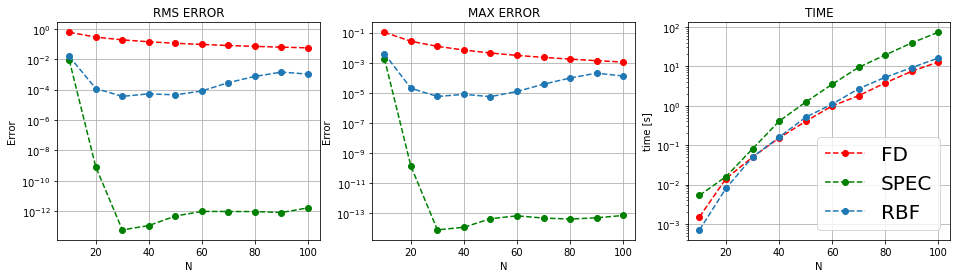

In [57]:
# semilogy plots

N = list(range(10, 101, 10))

plt.figure(figsize=(16,4))
plt.subplot("131")
plt.semilogy(N, rms_error_fd, "o--", c="red")
plt.semilogy(N, rms_error_spec, "o--", c="green")
plt.semilogy(N, rms_error_rbf, "o--")
plt.grid(); plt.title("RMS ERROR"); plt.xlabel("N"); plt.ylabel("Error")

plt.subplot("132")
plt.semilogy(N, max_error_fd, "o--", c="red")
plt.semilogy(N, max_error_spec, "o--", c="green")
plt.semilogy(N, max_error_rbf, "o--")
plt.grid(); plt.title("MAX ERROR"); plt.xlabel("N"); plt.ylabel("Error")

plt.subplot("133")
plt.semilogy(N, times_fd, "o--", c="red", label="FD")
plt.semilogy(N, times_spec, "o--", c="green", label="SPEC")
plt.semilogy(N, times_rbf, "o--", label="RBF")
plt.grid(); plt.title("TIME"); plt.xlabel("N"); plt.ylabel("time [s]")
plt.legend(loc="best", prop={'size': 20})
plt.show()

In the cell above we show the result in `semilogy` plots, while in the cell above we show the results in `loglog` plots. From these, a couple of things should be noted:

* Spectral method saturated quickly at $N=30$, and exhibit exponential convergence.
* RBF method is not accurate as spectral method. In fact, it also satures at $N=30$ but with an error much bigger that of spectral method. This impossibility of reducing further the error is due to the conditioning problems that appear as $N$ increases.
* Anyway, RBF method has better accuracy and convergence that FD method.
* In regard to time, RBF is faster than spectral methods. At $N=100$ is approximately $10$ faster.


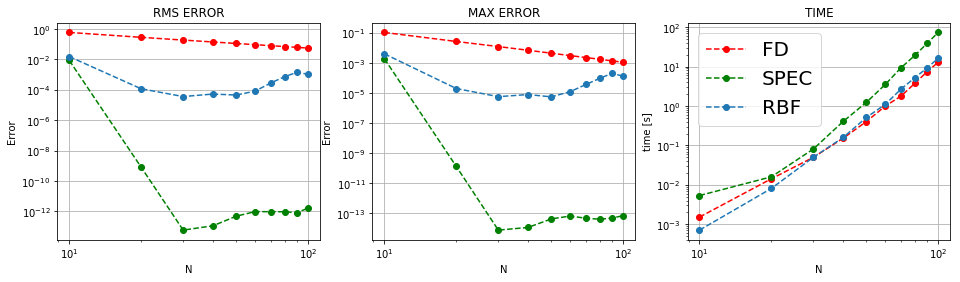

In [58]:
# loglog plots
plt.figure(figsize=(16,4))
plt.subplot("131")
plt.loglog(N, rms_error_fd, "o--", c="red")
plt.loglog(N, rms_error_spec, "o--", c="green")
plt.loglog(N, rms_error_rbf, "o--")
plt.grid(); plt.title("RMS ERROR"); plt.xlabel("N"); plt.ylabel("Error")

plt.subplot("132")
plt.loglog(N, max_error_fd, "o--", c="red")
plt.loglog(N, max_error_spec, "o--", c="green")
plt.loglog(N, max_error_rbf, "o--")
plt.grid(); plt.title("MAX ERROR"); plt.xlabel("N"); plt.ylabel("Error")

plt.subplot("133")
plt.loglog(N, times_fd, "o--", c="red", label="FD")
plt.loglog(N, times_spec, "o--", c="green", label="SPEC")
plt.loglog(N, times_rbf, "o--", label="RBF")
plt.grid(); plt.title("TIME"); plt.xlabel("N"); plt.ylabel("time [s]")
plt.legend(loc="best", prop={'size': 20})
plt.show()

#### Best $\epsilon$ for each N

At a first try, we empirically observed that keeping fixed the value of $\epsilon$ as we increased $N$ led to poor results, because of conditioning problems in the linear system. Thus, for each value of $N$ we find the _best value_ of $\epsilon \in [1,5]$. The boundary values of $1$ and $5$ were found empirically, i.e, lower and higher values doesn't improve the results at all.

In the cell below we show the values of $\epsilon$ obtained for each $N$.

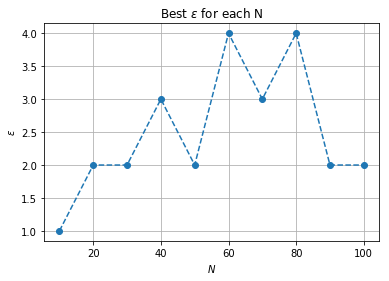

In [72]:
N = list(range(10, 101, 10))
plt.plot(N, eps_opt, "o--")
plt.grid()
plt.title("Best $\epsilon$ for each N")
plt.ylabel("$\epsilon$")
plt.xlabel("$N$")
plt.show()

#### How RBF method could be improved?

* In regard to accuracy and conditioning problems, the most obvious way is to use preconditioners. However, it is not easy to decide which preconditioner to use. An alternative is the RBF-QR method [1]. The main idea behind RBF-QR algorithm is to recognize that RBFs themselves constitute an ill-conditioned basis for a good approximation space. And the it proceeds to make a change of basis by expanding the RBFs in terms of other expansion functions. 
* In regard to computational complexity, many alternative are available speed-up the execution of RBF methods: Fast multipole methods, Domain Decomposition, Tree-Codes, among others.



####  What happen if we place the RBF nodes at Chebyshev points?

We propose as idea, verify what happen if we place Chebyshev points as the node points of the RBF. In the cells below we implement this, and test if over the test Poisson problem.

In [95]:
def rbf_cheb_poisson_solver(N=32, f_func=None, eps=2.5, verbose=True):
    # GENERATING THE CHEBYSHEV GRID
    _,x = cheb(N); y = x
    xx,yy = np.meshgrid(x, y)
    
    # node points
    x_nodes = xx.ravel()
    y_nodes = yy.ravel() 
    # interior points
    x_interior = xx[1:-1, 1:-1].ravel()
    y_interior = yy[1:-1, 1:-1].ravel()
    # boundary points
    x_boundary = np.concatenate( (xx[0,:],xx[1:,-1],xx[-1,:-1,],xx[1:-1,0]) )
    y_boundary = np.concatenate( (yy[0,:],yy[1:,-1],yy[-1,:-1,],yy[1:-1,0]) )
    
    lam = rbf_poisson_solver(f_func=f_func, x_nodes=x_nodes, y_nodes=y_nodes, 
                             x_interior=x_interior, y_interior=y_interior, 
                             x_boundary=x_boundary, y_boundary=y_boundary,
                             irregular=True, verbose=verbose)
    
    Phi = build_phi_matrix(x_nodes, y_nodes, x_nodes, y_nodes, eps=eps)
    u = np.dot(Phi, lam)
    uu = u.reshape((N+1,N+1))
    
    return xx,yy,uu

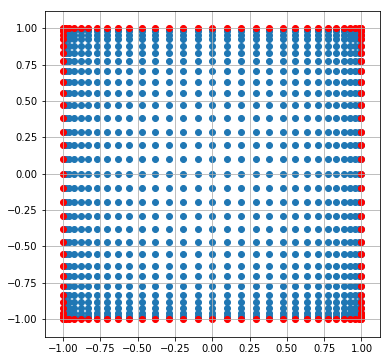

Number of interior points: 961
Number of boundary points: 128
Number of node points: 1089


In [128]:
xx,yy,uu = rbf_cheb_poisson_solver(N=32, f_func=f_test, eps=10)

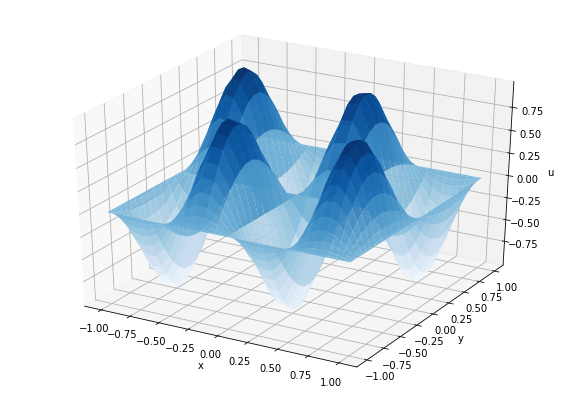

In [129]:
surface_plot(xx, yy, uu)

In [131]:
uu2 = u_test(xx,yy)
np.sqrt(np.sum((uu2-uu)**2))

0.12193126280234999

As you can see, by only using Chebyshev points as node points for the RBF interpolator doesn't produce improvements at all. Something interesting to research would be an RBF interpolator with variable $\epsilon$, depending on the distances between neighbor node points. In this way, we could have thin Gaussians near the boundaries and flat Gaussians at the center, which we suspect will lead to better results.

#### Extra tests: Varying the boundary conditions

Our current implementation also support setting custom boundary conditions. In the cells below we show an examples of how to use them, and its corresponding results.  

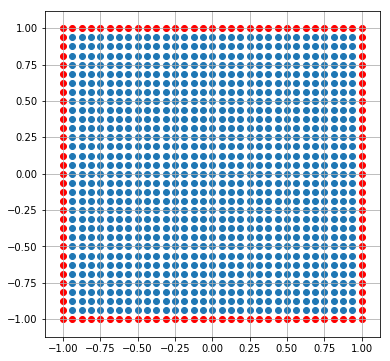

Number of interior points: 961
Number of boundary points: 128
Number of node points: 1089


In [643]:
# boundary conditions
g1 = lambda x : np.zeros(len(x)); g2 = lambda x : np.zeros(len(x))
g3 = lambda y : np.sin(np.pi*y); g4 = lambda y : np.sin(np.pi*y) 
g = {"bottom":g1, "top":g2, "left":g3, "right":g4}

xx,yy,uu = rbf_poisson_solver(N=32, f_func=f1, g_func=g)

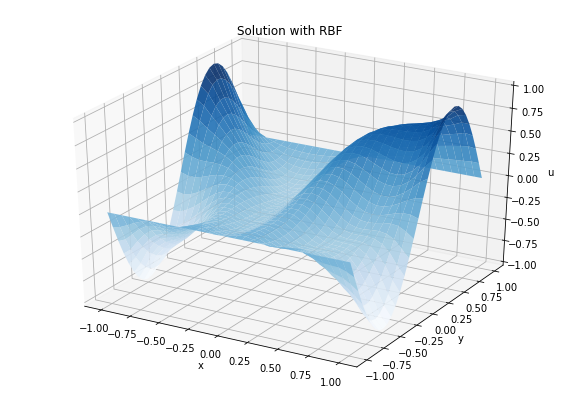

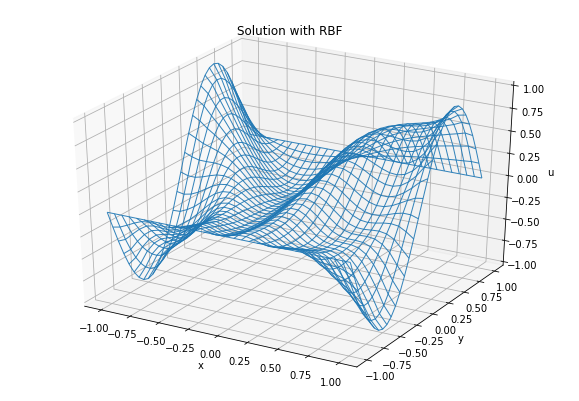

In [644]:
surface_plot(xx,yy,uu, title="Solution with RBF")
wireframe_plot(xx,yy,uu, title="Solution with RBF")

## 5. Solving PDEs over irregular domains

Even when (direct) RBF are not superior in accuracy to spectral methods in the task of solving PDEs, they have a __unique__ and __very useful feature__. This corresponds to its capacity  to _easily_ by adapted to work over __any__ irregular domain/geometry. 

This is possible, because the node points of the RBF approximation doesn't have any spatial restriction, thus, can be any set of scattered points.

In [686]:
####################################
# Some other test functions
###################################
def u_test3(x, y):
    return  0.1*np.sin(5*np.pi*x)*np.sin(5*np.pi*y)

def f_test3(x, y):
    return - 5*np.sin(5*np.pi*x)*np.sin(5*np.pi*y)

def u_test4(x, y):
    return np.exp(-1.*(x**2+y**2))

def f_test4(x, y):
    return (4*x**2 -2)*np.exp(-(x**2+y**2)) + (4*y**2 -2)*np.exp(-(x**2+y**2))

def u_test5(x, y):
    return x**3+y**3

def f_test5(x, y):
    return 6*x+6*y

In this section we use as test function:

\begin{align}
u(x,y) &= \exp(- (x^2+y^2)) \\
\Delta u(x,y) &= f(x,y) = (4x^2-2)\exp(- (x^2+y^2)) + (4y^2-2)\exp(- (x^2+y^2))
\end{align}

In the cells below we show plots for both functions

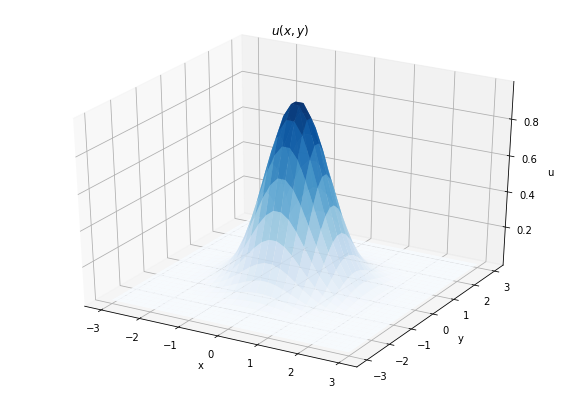

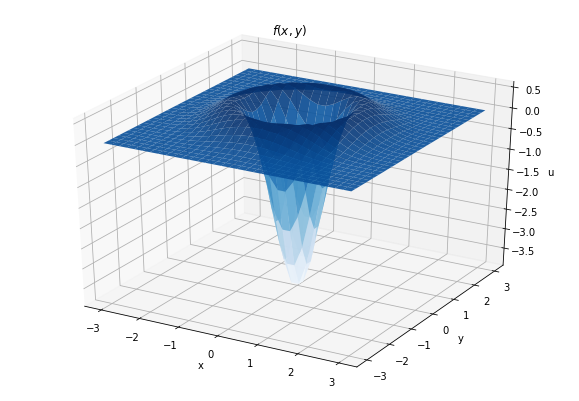

In [687]:
N = 32
x = np.linspace(-3.,3.,N)
y = np.linspace(-3.,3.,N)
xx,yy = np.meshgrid(x,y)

uu4 = u_test4(xx,yy)
ff4 = f_test4(xx,yy)

surface_plot(xx,yy,uu4, title="$u(x,y)$")
surface_plot(xx,yy,ff4, title="$f(x,y)$")

### 5.1 Halton points over a circular domain

As a first try to generate an irregular domain, we decided to use Halton points over a circular domain. Halton points were prefered over random points, because they are better spatially distributed.

In the cells below we generate the grid, and solve the Poisson problem with this set of node points.

In [688]:
def circular_grid(N):
    sequencer = ghalton.Halton(2)
    selected_points = []
    while True:
        points = 2*np.asarray(sequencer.get(50))-1
        for i in range(50):
            if points[i,0]**2+points[i,1]**2<=0.9:
                selected_points.append(points[i])
            if len(selected_points)==N:
                return np.asarray(selected_points)

In [689]:
# interior points
points = circular_grid(300)
x_interior = points[:,0]
y_interior = points[:,1]

# boundary points
x_boundary = np.cos(np.linspace(0, 2*np.pi, 50))
y_boundary = np.sin(np.linspace(0, 2*np.pi, 50))

# node points
x_nodes = np.hstack([x_interior, x_boundary])
y_nodes = np.hstack([y_interior, y_boundary])

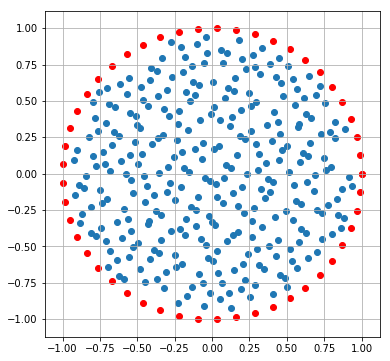

Number of interior points: 300
Number of boundary points: 50
Number of node points: 350


In [690]:
eps = 5.
lam = rbf_poisson_solver(f_func=f_test4, g_func=f_test4,
                         x_nodes=x_nodes, y_nodes=y_nodes,
                         x_interior=x_interior, y_interior=y_interior, 
                         x_boundary=x_boundary, y_boundary=y_boundary, 
                         irregular=True, eps=eps)

# generating interior/collocation and boundary points
N = 50
x = np.linspace(-1.5,1.5,N+1)
y = np.linspace(-1.5,1.5,N+1)
xx,yy = np.meshgrid(x, y)
x = xx.ravel()
y = yy.ravel()
Phi = build_phi_matrix(x_nodes, y_nodes, x, y, eps=eps)
u = np.dot(Phi, lam)
uu = u.reshape((N+1,N+1))

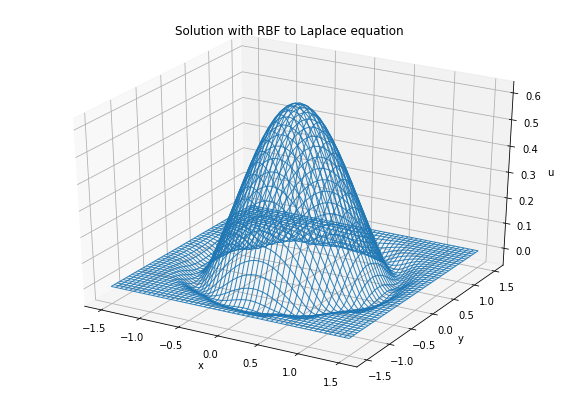

In [691]:
#surface_plot(xx,yy,uu, title="Solution with RBF to Laplace equation")
wireframe_plot(xx,yy,uu, title="Solution with RBF to Laplace equation")

As shown in the figure above, the problem is being solved over this irregular domain!. However, note that the approximation is not so good (specially at the boundaries). This happens because of __early conditioning problems__, due to node points very close to each other.

### 5.2 Solving PDEs over irregular domains with DistMesh generated grids


In order to avoid the previous conditioning problems due to node points very close to each other, we need to produce a __more uniform grid__ over the irregular domain. For such purpose we decided to use __DistMesh__ [2] for generation of unstructured triangular and tetrahedral meshes. The geometries of the domain are specified by __Signed Distance Functions__. 

For the actual mesh generation, __DistMesh__ uses the Delaunay routine and tries to optimize the node locations by a force-based smoothing procedure. The topology is regularly updated by Delaunay. The boundary points are only allowed to move tangentially to the boundary by projections using the distance function. This iterative procedure typically results in very well-shaped meshes.

<img src="signed_distance.png",width=560>

In what follows from this section, we solve the same previous Poisson equation but with irregular domain with different geometries. As you can see, with the current implementation of the `rbf_poisson_solver` it is very easy solve the Poisson problem in any geometry.

***
### Circular Domain

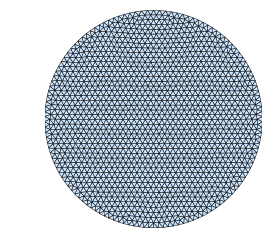

In [692]:
# signed distance function for circle
fd = lambda p: np.sqrt((p**2).sum(axis=1))-1.0
p, t = dm.distmesh2d(fd, dm.huniform, 0.05, (-1,-1,1.,1.))
x_nodes = p[:,0]
y_nodes = p[:,1]

# separating points between interior and boundary points
ind_boundary = np.where(np.abs(fd(p))<1e-3)
ind_interior = np.where(np.abs(fd(p))>1e-3)

x_interior = x_nodes[ind_interior]
y_interior = y_nodes[ind_interior]

x_boundary = x_nodes[ind_boundary]
y_boundary = y_nodes[ind_boundary]

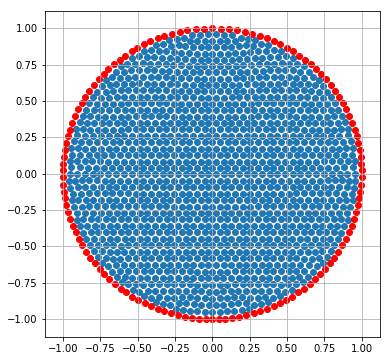

Number of interior points: 1324
Number of boundary points: 128
Number of node points: 1452


In [693]:
eps = 15.

lam = rbf_poisson_solver(f_func=f_test4, g_func=u_test4, 
                         x_nodes=x_nodes, y_nodes=y_nodes, 
                         x_interior=x_interior, y_interior=y_interior, 
                         x_boundary=x_boundary, y_boundary=y_boundary, 
                         eps=eps, irregular=True)

# generating interior/collocation and boundary points
N = 32
x = np.linspace(-1.5,1.5,N+1)
y = np.linspace(-1.5,1.5,N+1)
xx,yy = np.meshgrid(x, y)
x = xx.ravel()
y = yy.ravel()
Phi = build_phi_matrix(x_nodes, y_nodes, x, y, eps=eps)
u = np.dot(Phi, lam)
uu = u.reshape((N+1,N+1))

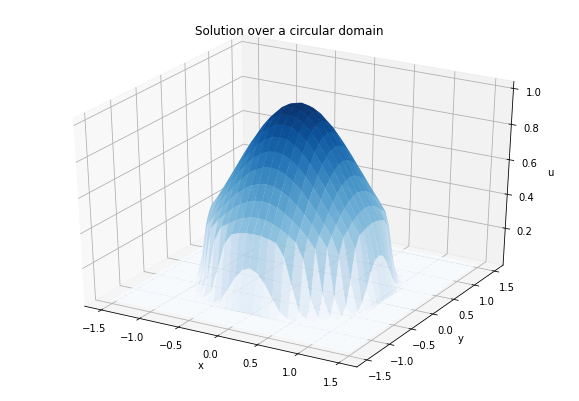

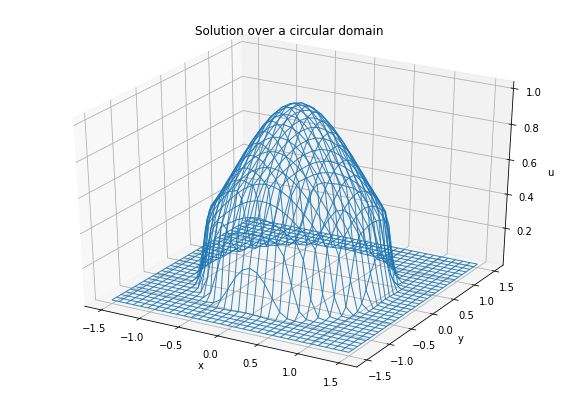

In [694]:
surface_plot(xx,yy,uu, title="Solution over a circular domain")
wireframe_plot(xx,yy,uu, title="Solution over a circular domain")

***

### Ring Domain

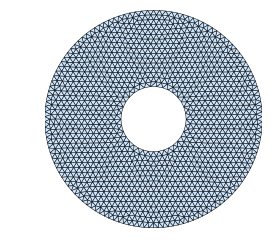

In [695]:
# signed distance function for a circle-ring
fd = lambda p : dm.ddiff( dm.dcircle(p,0.,0.,1.), dm.dcircle(p,0.,0.,0.3) )
p,t = dm.distmesh2d(fd, dm.huniform, 0.05, (-1,-1, 1,1))

x_nodes = p[:,0]
y_nodes = p[:,1]

# separating points between interior and boundary points
ind_boundary = np.where(np.abs(fd(p))<1e-3)
ind_interior = np.where(np.abs(fd(p))>1e-3)

x_interior = x_nodes[ind_interior]
y_interior = y_nodes[ind_interior]

x_boundary = x_nodes[ind_boundary]
y_boundary = y_nodes[ind_boundary]

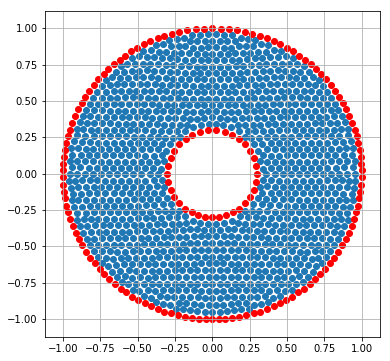

Number of interior points: 1158
Number of boundary points: 163
Number of node points: 1321


In [696]:
eps = 10.

lam = rbf_poisson_solver(f_func=f_test4, g_func=u_test4, 
                         x_nodes=x_nodes, y_nodes=y_nodes, 
                         x_interior=x_interior, y_interior=y_interior, 
                         x_boundary=x_boundary, y_boundary=y_boundary, 
                         eps=eps, irregular=True)

# generating interior/collocation and boundary points
N = 32
x = np.linspace(-1.5,1.5,N+1)
y = np.linspace(-1.5,1.5,N+1)
xx,yy = np.meshgrid(x, y)
x = xx.ravel()
y = yy.ravel()
Phi = build_phi_matrix(x_nodes, y_nodes, x, y, eps=eps)
u = np.dot(Phi, lam)
uu = u.reshape((N+1,N+1))

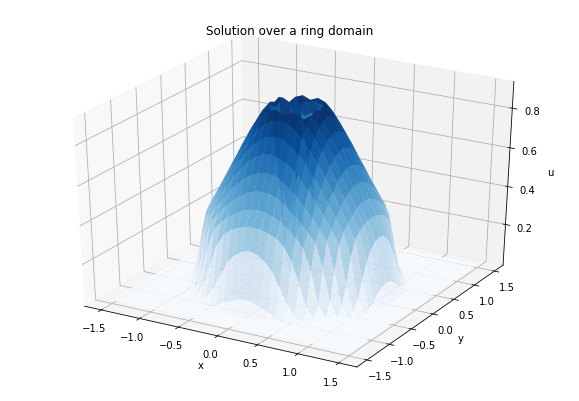

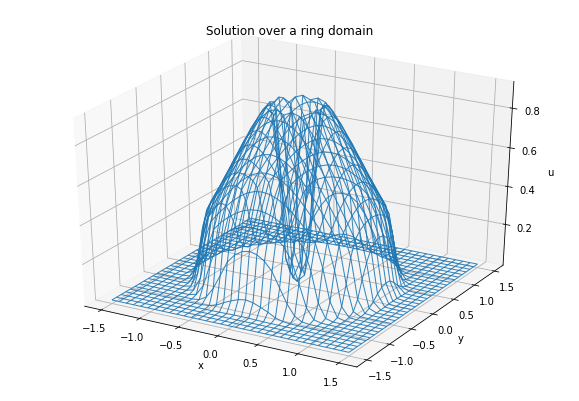

In [697]:
surface_plot(xx,yy,uu, title="Solution over a ring domain")
wireframe_plot(xx,yy,uu, title="Solution over a ring domain")

***
### Circle inside an square

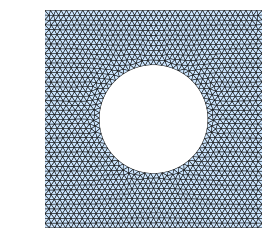

In [698]:
# signed distance function for a circle-ring
fd = lambda p: dm.ddiff(dm.drectangle(p,-1,1,-1,1), dm.dcircle(p,0,0,0.5))
fh = lambda p: np.ones(len(p))
p,t = dm.distmesh2d(fd, fh, 0.05, (-1,-1,1,1),
                     [(-1,-1),(-1,1),(1,-1),(1,1)])

x_nodes = p[:,0]
y_nodes = p[:,1]

# separating points between interior and boundary points
ind_boundary = np.where(np.abs(fd(p))<1e-3)
ind_interior = np.where(np.abs(fd(p))>1e-3)

x_interior = x_nodes[ind_interior]
y_interior = y_nodes[ind_interior]

x_boundary = x_nodes[ind_boundary]
y_boundary = y_nodes[ind_boundary]

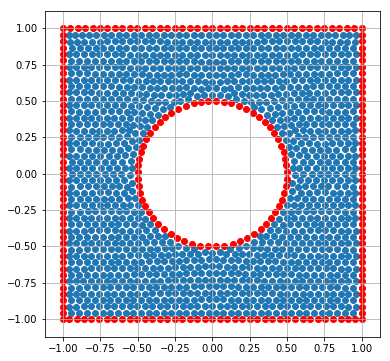

Number of interior points: 1312
Number of boundary points: 234
Number of node points: 1546


In [699]:
eps = 10.

lam = rbf_poisson_solver(f_func=f_test4, g_func=u_test4, 
                         x_nodes=x_nodes, y_nodes=y_nodes, 
                         x_interior=x_interior, y_interior=y_interior, 
                         x_boundary=x_boundary, y_boundary=y_boundary, 
                         eps=eps, irregular=True)

# generating interior/collocation and boundary points
N = 32
x = np.linspace(-1.5,1.5,N+1)
y = np.linspace(-1.5,1.5,N+1)
xx,yy = np.meshgrid(x, y)
x = xx.ravel()
y = yy.ravel()
Phi = build_phi_matrix(x_nodes, y_nodes, x, y, eps=eps)
u = np.dot(Phi, lam)
uu = u.reshape((N+1,N+1))

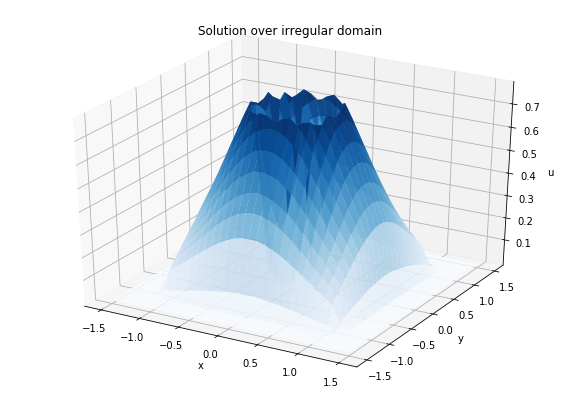

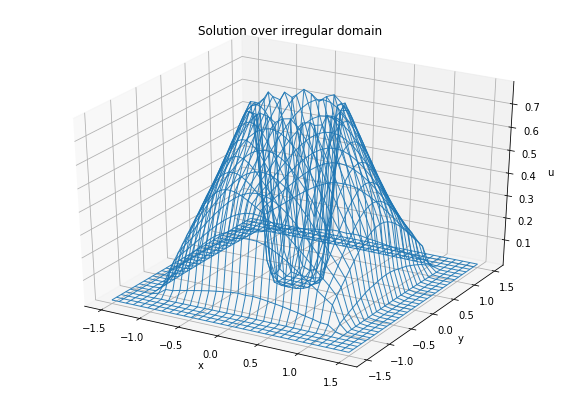

In [700]:
surface_plot(xx,yy,uu, title="Solution over irregular domain")
wireframe_plot(xx,yy,uu, title="Solution over irregular domain")

***
### Polygonal domain

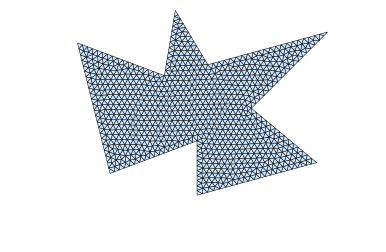

In [701]:
# signed distance function for a circle-ring
pv = np.array([(-0.4,-0.5),(0.4,-0.2),(0.4,-0.7),(1.5,-0.4),(0.9,0.1),
                   (1.6,0.8),(0.5,0.5),(0.2,1.0),(0.1,0.4),(-0.7,0.7),
                   (-0.4,-0.5)])
fd = lambda p: dm.dpoly(p, pv)
p,t = dm.distmesh2d(fd, dm.huniform, 0.05, (-1,-1, 2,1), pv)

x_nodes = p[:,0]
y_nodes = p[:,1]

# separating points between interior and boundary points
ind_boundary = np.where(np.abs(fd(p))<1e-3)
ind_interior = np.where(np.abs(fd(p))>1e-3)

x_interior = x_nodes[ind_interior]
y_interior = y_nodes[ind_interior]

x_boundary = x_nodes[ind_boundary]
y_boundary = y_nodes[ind_boundary]

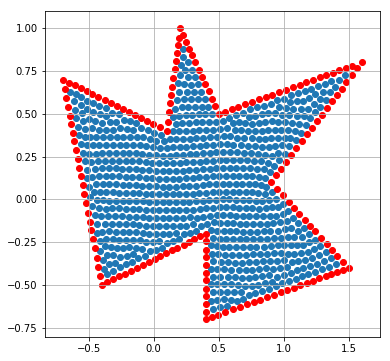

Number of interior points: 725
Number of boundary points: 168
Number of node points: 893


In [702]:
eps = 10.

lam = rbf_poisson_solver(f_func=f_test4, g_func=u_test4, 
                         x_nodes=x_nodes, y_nodes=y_nodes, 
                         x_interior=x_interior, y_interior=y_interior, 
                         x_boundary=x_boundary, y_boundary=y_boundary, 
                         eps=eps, irregular=True)

# generating interior/collocation and boundary points
N = 32
x = np.linspace(-1.5,2.5,N+1)
y = np.linspace(-1.75,2.,N+1)
xx,yy = np.meshgrid(x, y)
x = xx.ravel()
y = yy.ravel()
Phi = build_phi_matrix(x_nodes, y_nodes, x, y, eps=eps)
u = np.dot(Phi, lam)
uu = u.reshape((N+1,N+1))

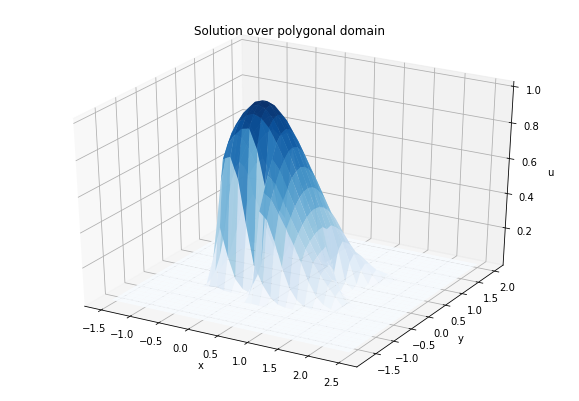

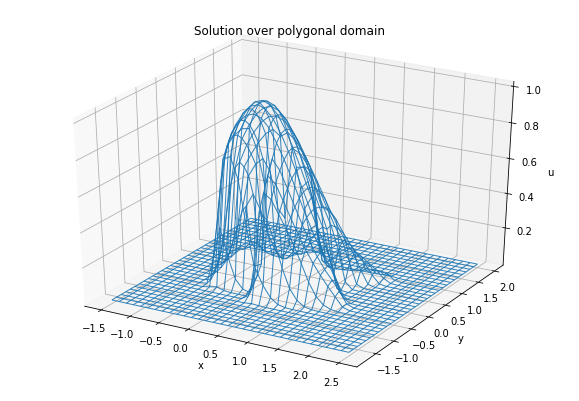

In [703]:
surface_plot(xx,yy,uu, title="Solution over polygonal domain")
wireframe_plot(xx,yy,uu, title="Solution over polygonal domain")



## Boundary Layer Problems

A __boundary layer__ is a narrow region for which the solution of a partial differential equation __change rapidly__. Usually, the thickness of the boundary layer is controlled by a parameter $\epsilon$, and it should go to $0$ as $\epsilon \rightarrow 0$.

In many cases the boundary layer is actually at the boundary of the domain of the PDE. In such cases, Chebyshev methods are useful because has a high density of points near the boundary. However, the boundary layer could by in a different region of the domain $\Omega$. In such cases, RBF methods are useful because __we can arbitrarily select the position of the node points__.


As a final test we test our current implementation of the RBF solver for Poisson equations, to show how could this be used to solve boundary layer problems. 

In the equation below we propose the following boundary layer problem:

\begin{align}
u(x,y) &= \exp\left(-\frac{x^2+y^2}{\epsilon^2}\right) + 0.1 \sin(5\pi x)\sin(5\pi y) \\
\Delta u(x,y) &= f(x,y) = \frac{4}{\epsilon^2}\left( \frac{x^2}{\epsilon^2}+ \frac{y^2}{\epsilon^2} - 1 \right) \exp\left(-\frac{x^2+y^2}{\epsilon^2}\right)  - 5 \pi^2 \sin(5\pi x) \sin(5 \pi y)
\end{align}

with boundary conditions $u(\partial \Omega) = f(\partial \Omega)$. Here the thickness of the layer is controlled by $\epsilon$. 

In the cells below we show plot for the function and its Laplacian.



In [718]:
eps = 0.1

def u_testb(x, y, eps=eps):
    return np.exp(-(x**2+y**2)/eps**2) + 0.1*np.sin(5*np.pi*x)*np.sin(5*np.pi*y)

def f_testb(x,y, eps=eps):
    return (4/eps**2)*(x**2/eps**2 + y**2/eps**2 -1)*np.exp(-(x**2+y**2)/eps**2) - 5*np.sin(5*np.pi*x)*np.sin(5*np.pi*y)

In [719]:
N = 40
x = np.linspace(-1., 1., N)
y = np.linspace(-1., 1., N)
xx,yy = np.meshgrid(x,y)

uu = u_testb(xx, yy)
ff = f_testb(xx,yy)

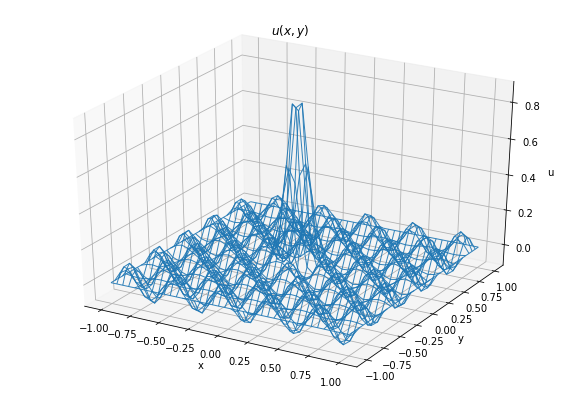

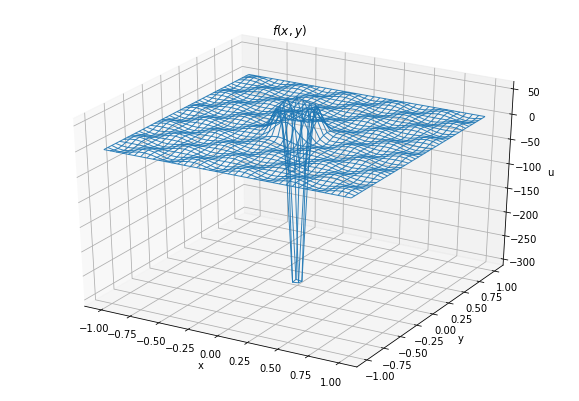

In [720]:
#surface_plot(xx,yy,uu)
wireframe_plot(xx,yy,uu, title="$u(x,y)$")
wireframe_plot(xx,yy,ff, title="$f(x,y)$")

***
The function in the cell below computes the solution to the boundary layer problem with the spectral and RBF methods, for grid sizes `N`, layer thickness `eps_layer` and shape parameter `eps_rbf`. 

In [721]:
def compare_solution(N=32, eps_layer=0.1, eps_rbf=10.):
    def u_testb(x, y, eps=eps_layer):
        return np.exp(-(x**2+y**2)/eps**2) + 0.1*np.sin(5*np.pi*x)*np.sin(5*np.pi*y)
    def f_testb(x,y, eps=eps_layer):
        return (4/eps**2)*(x**2/eps**2 + y**2/eps**2 -1)*np.exp(-(x**2+y**2)/eps**2) - \
                5*np.sin(5*np.pi*x)*np.sin(5*np.pi*y)
    
    xx1,yy1,vv1 = spectral_poisson_solver(N=N, f_func=f_testb)
    #wireframe_plot(xx,yy,uu, title="Spectral solution")
    uu1 = u_testb(xx1,yy1)
    title1 = "$SPECTRAL - ||\cdot||_\infty =$ {0}".format(np.linalg.norm((uu1-vv1).ravel(), ord=np.inf))
    
    
    xx2,yy2,vv2 = rbf_poisson_solver(N=N, f_func=f_testb, verbose=False, eps=eps_rbf)
    #wireframe_plot(xx,yy,uu,title="RBF solution")
    uu2 = u_testb(xx2,yy2)
    title2 = "$RBF - ||\cdot||_\infty =$ {0}".format(np.linalg.norm((uu2-vv2).ravel(), ord=np.inf))
    
    wireframe_plot2(xx1, yy1, vv1, xx2, yy2, vv2, figsize=(18,10), 
                    title1=title1, title2=title2)

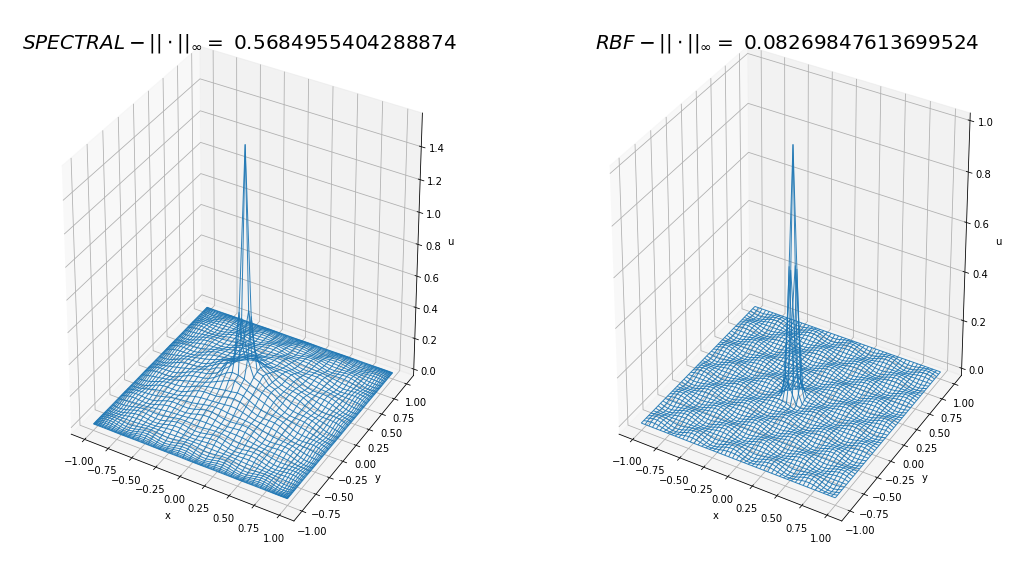

In [722]:
compare_solution(N=50, eps_layer=0.05, eps_rbf=10.)

And, in the cell below we present an interactive widget which allows to test different configurations to compare the methods.

In [723]:
N_values = [30,40,50,60,70,80]
eps_layer_values = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
eps_rbf_values = [10.,15.,20.,25.]
interact(compare_solution, N=N_values, eps_layer=eps_layer_values, eps_rbf = eps_rbf_values);

interactive(children=(Dropdown(description='N', options=(30, 40, 50, 60, 70, 80), value=30), Dropdown(description='eps_layer', options=(0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01), value=0.1), Dropdown(description='eps_rbf', options=(10.0, 15.0, 20.0, 25.0), value=10.0), Output()), _dom_classes=('widget-interact',))

Comments on the results:
* RBF method behaves much more better than spectral method, as `eps_layer` approaches better (the differences are conclusive).
* The only way to improve the results in spectral methods, is by increasing $N$. However, this leads to an increase of the computational time required to compute the solution.
* With lower values of `eps_layer` the RBF method obtains good result no needing to increase to much $N$. However, as $N$ increases, we have to reduce `eps_rbf` accordingly.
* Even better results could be obtained with RBF Methods by __clustering the node points__ near the boundary layer.

***
***
## 7. Conclusions and final remarks

#### Pros of RBF methods for computing differentiation matrices
* Easily extensible to non-square [-1,1] domains, and arbitrarily irregular domains.
* Applicable to more realistic scenarios, where the value of $\Delta u$ is only accessible at scattered points in a  irregular domain.
* Provides better results in __boundary layer problems__ because of the possibility of moving the positions of the nodes.
* Better accuracy could be achieved with RBF-QR method [1]. Better performance could be achieved with Fast multipole methods and Domain Decompositions, among other techniques.

#### Contras of RBF methods for computing differentiation matrices
* We need to set the shape parameter $\epsilon$ accordingly to obtain a accurate solution.
* As $\epsilon \rightarrow 0$ the interpolation matrix $\Phi$ becomes ill-conditioned.


## References

__[1]__ Larsson, E., Lehto, E., Heryudono, A., & Fornberg, B. (2013). Stable computation of differentiation matrices and scattered node stencils based on Gaussian radial basis functions. SIAM Journal on Scientific Computing, 35(4), A2096-A2119.


__[2]__ Persson, P. O., & Strang, G. (2004). A simple mesh generator in MATLAB. SIAM review, 46(2), 329-345.

__[3]__ Trefethen, L. N. (2000). Spectral methods in MATLAB (Vol. 10). Siam.

__[4]__ Sauer, T. (2012). Numerical Analysis (2nd).